In [46]:
!pip install pymysql pandas
!pip install keras
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [59]:
import pandas as pd
import os
import getpass
from sqlalchemy import create_engine,text
from sqlalchemy import URL, create_engine
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

# Database connection information

In [63]:
DB_HOST = "den1.mysql6.gear.host"
DB_NAME = "situation"
DB_USER = "situation"
#DB_PASSWORD = input("Enter your database password: ")
DB_PASSWORD = getpass.getpass("Enter your database password: ")
#clear_output()

Enter your database password: ··········


In [64]:
# Establish connection to the database
DATABASE_URI = f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}"
engine = create_engine(DATABASE_URI)

# Fetch data from the database using read_sql_table

In [65]:
df_degradation = pd.read_sql_table('g7_les_unit_operations_degradation', engine)
df_params = pd.read_sql_table('g7_les_uo_params', engine)

In [66]:
# display the first rows of the DataFrames
print("Degradation Data:")
print(df_degradation.head())

print("\nParameters Data:")
print(df_params.head())

Degradation Data:
   id reactor_robot_id experiment_group workflow_step parameter_name  \
0   1            RR101           Group2         Step1      Viscosity   
1   2            RR104           Group3         Step1      Viscosity   
2   3            RR102           Group1         Step1       Pressure   
3   4            RR101           Group2         Step1      Viscosity   
4   5            RR104           Group2         Step1       Pressure   

   parameter_value      execution_time  inefficiency_score  
0       344.139346 2024-05-13 11:30:53            0.087365  
1       218.951722 2024-05-13 11:35:53            0.023142  
2       364.330959 2024-05-13 11:40:53            0.142511  
3       274.381862 2024-05-13 11:45:53            0.096173  
4       364.520609 2024-05-13 11:50:53            0.147191  

Parameters Data:
  Unit_Operation_ID        UOName  \
0             UO001  Distillation   
1             UO002           Dry   
2             UO003        Mixing   
3             UO0

In [73]:
# display column names
print("\nColumn names of df_degradation:")
print(df_degradation.columns)

print("\nColumn names of df_params:")
print(df_params.columns)


Column names of df_degradation:
Index(['id', 'reactor_robot_id', 'experiment_group', 'workflow_step',
       'parameter_name', 'parameter_value', 'execution_time',
       'inefficiency_score'],
      dtype='object')

Column names of df_params:
Index(['Unit_Operation_ID', 'UOName', 'UODescription', 'UOParams'], dtype='object')


# CSV files

In [74]:
# reate CSV files
df_degradation.to_csv("g7_les_unit_operations_degradation.csv", index=False)
df_params.to_csv("g7_les_uo_params.csv", index=False)

# read CSV files
read_df_degradation = pd.read_csv("g7_les_unit_operations_degradation.csv")
read_df_params = pd.read_csv("g7_les_uo_params.csv")

# display the first rows of the read DataFrames
print("\nRead Degradation Data:")
print(read_df_degradation.head())

print("\nRead Parameters Data:")
print(read_df_params.head())


Read Degradation Data:
   id reactor_robot_id experiment_group workflow_step parameter_name  \
0   1            RR101           Group2         Step1      Viscosity   
1   2            RR104           Group3         Step1      Viscosity   
2   3            RR102           Group1         Step1       Pressure   
3   4            RR101           Group2         Step1      Viscosity   
4   5            RR104           Group2         Step1       Pressure   

   parameter_value       execution_time  inefficiency_score  
0       344.139346  2024-05-13 11:30:53            0.087365  
1       218.951722  2024-05-13 11:35:53            0.023142  
2       364.330959  2024-05-13 11:40:53            0.142511  
3       274.381862  2024-05-13 11:45:53            0.096173  
4       364.520609  2024-05-13 11:50:53            0.147191  

Read Parameters Data:
  Unit_Operation_ID        UOName  \
0             UO001  Distillation   
1             UO002           Dry   
2             UO003        Mixing   


# Extract features and target variable

In [75]:
if 'UOParams' in df_params.columns:
    features = df_params[['UOParams']]
else:
    print("Column 'UOParams' not found in df_params. Available columns are:", df_params.columns)
    features = pd.DataFrame()  # Empty DataFrame for features

if 'inefficiency_score' in df_degradation.columns:
    target = df_degradation['inefficiency_score']
else:
    print("Column 'inefficiency_score' not found in df_degradation. Available columns are:", df_degradation.columns)
    target = pd.Series()  # Empty Series for target

print("\nFeatures:")
if not features.empty:
    print(features.head())
else:
    print("No features available.")

print("\nTarget:")
if not target.empty:
    print(target.head())
else:
    print("No target variable available.")


Features:
                                            UOParams
0  ['Mixture', 'Temperature', 'Pressure', 'Heatin...
1  ['Product', 'DryingMethod', 'DryingTemperature...
2  [{'Ingredients' : {'Ingredient': {'Name', 'Qua...
3  ['MaterialToBeWashed', 'Impurities', 'WashingS...
4  ['Substance', 'Amount', 'Duration', 'BalanceTy...

Target:
0    0.087365
1    0.023142
2    0.142511
3    0.096173
4    0.147191
Name: inefficiency_score, dtype: float64


# Recurrent Neural Network (RNN)

Degradation Data:
   id reactor_robot_id experiment_group workflow_step parameter_name  \
0   1            RR101           Group2         Step1      Viscosity   
1   2            RR104           Group3         Step1      Viscosity   
2   3            RR102           Group1         Step1       Pressure   
3   4            RR101           Group2         Step1      Viscosity   
4   5            RR104           Group2         Step1       Pressure   

   parameter_value       execution_time  inefficiency_score  
0       344.139346  2024-05-13 11:30:53            0.087365  
1       218.951722  2024-05-13 11:35:53            0.023142  
2       364.330959  2024-05-13 11:40:53            0.142511  
3       274.381862  2024-05-13 11:45:53            0.096173  
4       364.520609  2024-05-13 11:50:53            0.147191  
Epoch 1/50
2/2 [==============================] - 7s 894ms/step - loss: 0.0129 - val_loss: 0.0078
Epoch 2/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0109 -

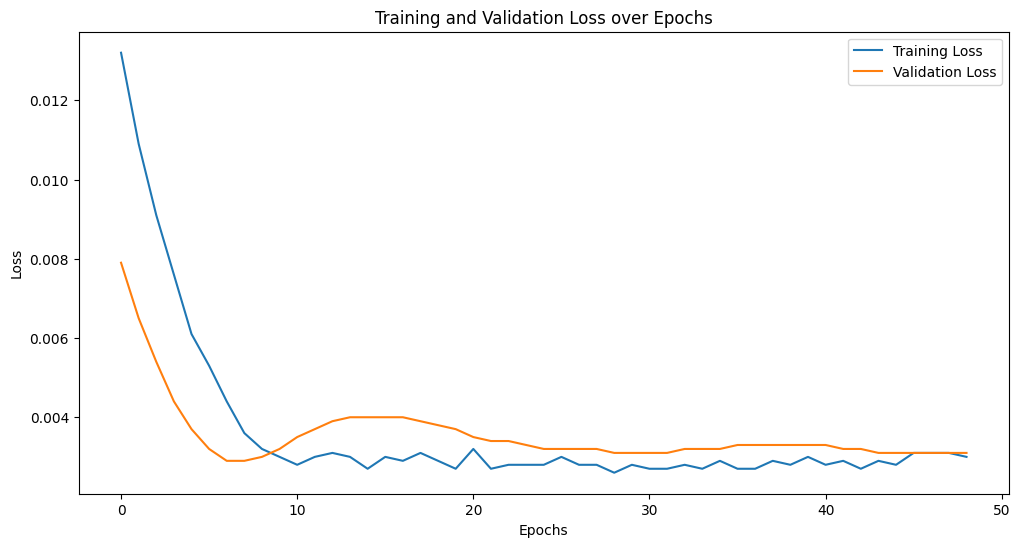

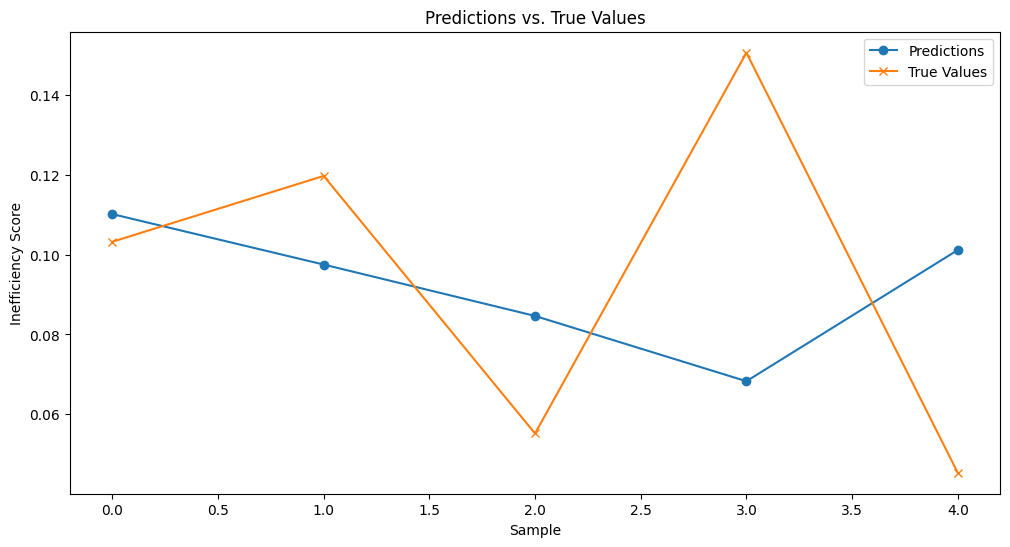

In [76]:
# Load the degradation data
df_degradation = pd.read_csv("g7_les_unit_operations_degradation.csv")

# Display the first few rows of the degradation data
print("Degradation Data:")
print(df_degradation.head())

# Extract features and target variable
features = df_degradation[['parameter_value']]
target = df_degradation['inefficiency_score']

# Scale the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Reshape features for RNN (samples, timesteps, features)
# Here we assume each sample has only one timestep and one feature
features_scaled = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions if necessary (depends on the problem)
# predictions = scaler.inverse_transform(predictions)

# Display the first few predictions
print("Predictions:")
print(predictions[:5])

# Display the first few true values
print("True values:")
print(y_test[:5].values)

# loss values from the output
training_loss = [0.0132, 0.0109, 0.0091, 0.0076, 0.0061, 0.0053, 0.0044, 0.0036, 0.0032, 0.0030, 0.0028, 0.0030, 0.0031, 0.0030, 0.0027, 0.0030, 0.0029, 0.0031, 0.0029, 0.0027, 0.0032, 0.0027, 0.0028, 0.0028, 0.0028, 0.0030, 0.0028, 0.0028, 0.0026, 0.0028, 0.0027, 0.0027, 0.0028, 0.0027, 0.0029, 0.0027, 0.0027, 0.0029, 0.0028, 0.0030, 0.0028, 0.0029, 0.0027, 0.0029, 0.0028, 0.0031, 0.0031, 0.0031, 0.0030]
validation_loss = [0.0079, 0.0065, 0.0054, 0.0044, 0.0037, 0.0032, 0.0029, 0.0029, 0.0030, 0.0032, 0.0035, 0.0037, 0.0039, 0.0040, 0.0040, 0.0040, 0.0040, 0.0039, 0.0038, 0.0037, 0.0035, 0.0034, 0.0034, 0.0033, 0.0032, 0.0032, 0.0032, 0.0032, 0.0031, 0.0031, 0.0031, 0.0031, 0.0032, 0.0032, 0.0032, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0032, 0.0032, 0.0031, 0.0031, 0.0031, 0.0031, 0.0031, 0.0031]

plt.figure(figsize=(12, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# example predictions and actual values from the output
predictions = np.array([0.11011679, 0.09748709, 0.08462124, 0.06828032, 0.10111754])
true_values = np.array([0.10318717, 0.11967343, 0.05519964, 0.15051465, 0.04537667])

plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predictions', marker='o')
plt.plot(true_values, label='True Values', marker='x')
plt.xlabel('Sample')
plt.ylabel('Inefficiency Score')
plt.title('Predictions vs. True Values')
plt.legend()
plt.show()


Epoch 1/50
1/1 [==============================] - 10s 10s/step - loss: 0.0097 - val_loss: 0.0204
Epoch 2/50
1/1 [==============================] - 0s 72ms/step - loss: 0.0087 - val_loss: 0.0176
Epoch 3/50
1/1 [==============================] - 0s 70ms/step - loss: 0.0078 - val_loss: 0.0151
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.0069

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 82ms/step - loss: 0.0069 - val_loss: 0.0128
Epoch 5/50
1/1 [==============================] - 0s 90ms/step - loss: 0.0062 - val_loss: 0.0108
Epoch 6/50
1/1 [==============================] - 0s 74ms/step - loss: 0.0055 - val_loss: 0.0091
Epoch 7/50
1/1 [==============================] - 0s 82ms/step - loss: 0.0049 - val_loss: 0.0077
Epoch 8/50
1/1 [==============================] - 0s 79ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 9/50
1/1 [==============================] - 0s 78ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 10/50
1/1 [==============================] - 0s 77ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 11/50
1/1 [==============================] - 0s 73ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 12/50
1/1 [==============================] - 0s 88ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 13/50
1/1 [==============================] - 0s 100ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 14/50
1/1 [===================

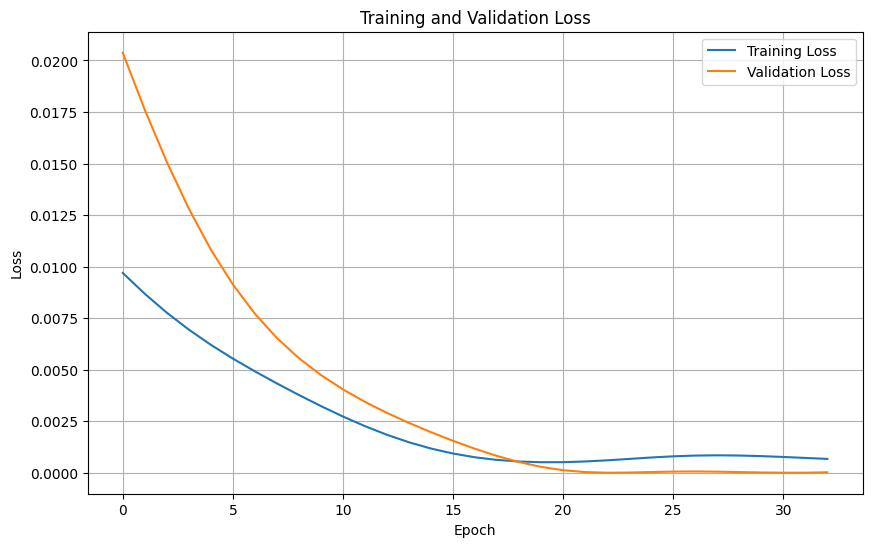

In [77]:
degradation_data = pd.DataFrame({
    'reactor_robot_id': ['RR101', 'RR104', 'RR102', 'RR101', 'RR104'],
    'experiment_group': ['Group2', 'Group3', 'Group1', 'Group2', 'Group2'],
    'workflow_step': ['Step1', 'Step1', 'Step1', 'Step1', 'Step1'],
    'parameter_name': ['Viscosity', 'Viscosity', 'Pressure', 'Viscosity', 'Pressure'],
    'parameter_value': [344.139346, 218.951722, 364.330959, 274.381862, 364.520609],
    'execution_time': pd.to_datetime(['2024-05-13 11:30:53', '2024-05-13 11:35:53', '2024-05-13 11:40:53',
                                      '2024-05-13 11:45:53', '2024-05-13 11:50:53']),
    'inefficiency_score': [0.087365, 0.023142, 0.142511, 0.096173, 0.147191]
})

parameters_data = pd.DataFrame({
    'Unit_Operation_ID': ['UO001', 'UO002', 'UO003', 'UO004', 'UO005'],
    'UOName': ['Distillation', 'Dry', 'Mixing', 'Washing', 'Weighing'],
    'UODescription': ['Separation of components in a liquid mixture', 'Removal of moisture or water',
                      'Combine two or more substances', 'Removal of impurities', 'Transfer specific amounts'],
    'UOParams': [['Mixture', 'Temperature', 'Pressure', 'HeatingRate'], ['Product', 'DryingMethod'],
                 [{'Ingredients': {'Ingredient': {'Name', 'Quantity'}}}, 'Duration'],
                 ['MaterialToBeWashed', 'Impurities', 'WashingSolution'], ['Substance', 'Amount', 'Duration']]
})


# In this example, we assume using 'parameter_value' as feature and 'inefficiency_score' as label
X = degradation_data['parameter_value'].values.reshape(-1, 1)
y = degradation_data['inefficiency_score'].values

# Data normalization
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Reshape for LSTM model (adjust based on number of time points and features)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Define the model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_reshaped, y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Visualization of loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
